# 勾配クリッピング
勾配クリッピングにより勾配の必要以上の増加を抑制し、勾配爆発を防ぐことができます。

## 勾配クリッピングのコード
勾配クリッピングのコードは、以下のように関数で記述することが可能です。

In [1]:
import numpy as np

def grad_clip(grads, max_norm):  # grads: 層の勾配  max_norm: ノルムの最大値
    norm = np.sqrt(np.sum(grads*grads))  # 二乗和の平方根でL2ノルムを計算
    r = max_norm / norm
    if r < 1:
        clipped_grads = grads * r  # ノルムが最大値を超えた場合、勾配が小さくなるように調整
    return clipped_grads

a = np.array([[3, 4]])
max_norm = 4
print(grad_clip(a, 4))

[[2.4 3.2]]


## RNNの各設定
Kerasを用いて、RNNに勾配クリッピングを導入します。  
まずは、RNNの各設定です。

In [2]:
n_rnn = 10  # 時系列の数
batch_size = 8
epochs = 20
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。

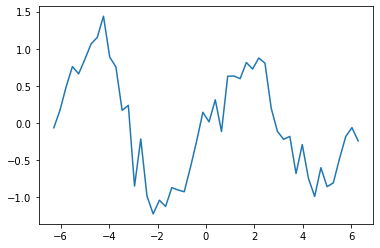

(40, 10, 1)
(40, 10, 1)


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(x_data)  + 0.3*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_sample = len(x_data)-n_rnn
x = np.zeros((n_sample, n_rnn))
t = np.zeros((n_sample, n_rnn))
for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]

x = x.reshape(n_sample, n_rnn, 1)
print(x.shape)
t = t.reshape(n_sample, n_rnn, 1)
print(t.shape)

## 勾配クリッピングの実装
Kerasでは、optimizerに勾配クリッピングの設定をします。  
ノルムの最大値を様々な値に設定し、勾配クリッピングの効果を確認します。

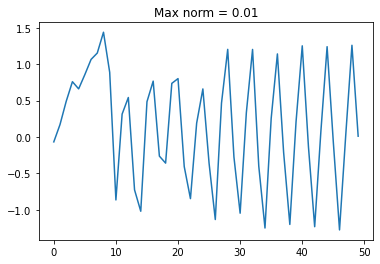

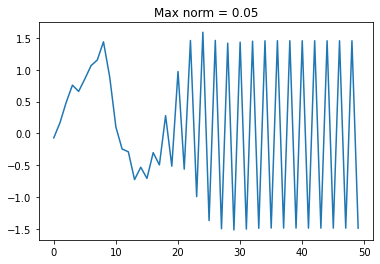

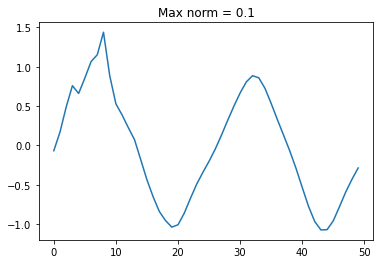

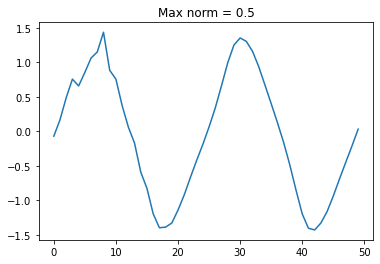

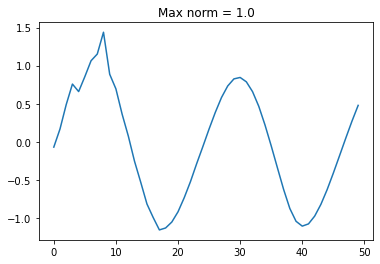

In [4]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras import optimizers

for max_norm in [0.01, 0.05, 0.1, 0.5, 1.0]:   # 様々なノルムの最大値で学習を行う
    model = Sequential()
    model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
    model.add(Dense(n_out, activation="linear"))
    # optimizerで勾配クリッピングの設定を行う。clipnormにノルムの最大値を設定。
    model.compile(loss="mean_squared_error", optimizer=optimizers.SGD(clipnorm=max_norm)) 
    history = model.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)  #verbose=0で経過の表示を行わない
    
    predicted = x[0].reshape(-1)
    for i in range(0, n_sample):
        y = model.predict(predicted[-n_rnn:].reshape(1, -1, 1))
        predicted = np.append(predicted, y[0][n_rnn-1][0])

    plt.plot(np.arange(len(predicted)), predicted)
    plt.title("Max norm = " + str(max_norm))
    plt.show()

ノルムの最大値が小さすぎると、勾配が小さすぎて学習がうまく進みません。  
ノルムがの最大値がある程度大きければ、問題なく学習できるようになります。  

このように、勾配クリッピングには勾配を抑制する効果があります。  
勾配を抑制することにより勾配爆発を防ぐ効果がありますが、学習を妨げないようにノルムの最大値を適切に設定する必要があります。

## 課題
エポック数を変化させて、勾配クリッピングの効果がどのように変わるか確かめてみましょう。